# Baseline Code

## 라이브러리 불러오기

In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 데이터 받아오기

In [36]:
def load_chat_data(filepath):
    df = pd.read_csv(filepath)
    
    labels = df["class"].astype(str).tolist()
    sentences = df["conversation"].astype(str).tolist()

    return labels, sentences

In [37]:
original_train_data_path ="../data/original_data/original_train.csv"
# 아래 경로는 예시입니다.
augmented_train_data_path ="../data/augmentation_data/augmentation_train.csv"
daily_train_data_path ="../data/daily_data/daily_train.csv"

# 일반 대화 개수 정하는 변수
daily_data_num = 1000

labels, sentences = load_chat_data(original_train_data_path)
daily_labels, daily_sentences = load_chat_data(daily_train_data_path)

# 필요한 수만큼 자르기
daily_labels_subset = daily_labels[:daily_data_num]
daily_sentences_subset = daily_sentences[:daily_data_num]

# 기존 데이터에 덧붙이기
labels += daily_labels_subset
sentences += daily_sentences_subset

print("레이블 예시:", labels[:1])
print("대화 예시:", sentences[:1])

레이블 예시: ['협박 대화']
대화 예시: ['지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.\n 정말 잘못했습니다.\n 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.\n 죄송합니다. 정말 잘못했습니다.\n 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.\n 선택 못하겠습니다. 한번만 도와주세요.\n 그냥 다 죽여버려야겠군. 이의 없지?\n 제발 도와주세요.']


## 데이터 전처리

### 데이터 전처리 함수 불러와서 사용

In [38]:
from preprocessing import *

example = "와!진짜대박123진짜"
print(preprocess_sentence(example))

와 ! 진짜대박 123 진짜


In [39]:
sentences = [preprocess_sentence(s) for s in sentences]
print("대화 예시:", sentences[7])

대화 예시: 경비아저씨 내차에 경고장 붙였어요 ? 내가 여기 몇년째 사는데 아직도 내차인줄 모르고 이딴식으로 경고장을 붙여 ? 입주민께서 정해진 주차자리가 아닌 통로에 계속 주차하셔서 입주민들 항의가 계속 들어옵니다 . 내가 항상 대는 거기 자리가 없으니까 그렇지 . 내차 이거 어떻게 할거요 ? 얼마짜린줄 알아 ? 수차례 인터폰도 드렸고 경고장을 올렸으나 몇일째 그대로 인지라 아파트규약에 맞춰 어쩔수 없었습니다 그렇다고 본드로 붙이면 어떻게 ? 당장 이거 깨끗히 원상복구시키고 세차해와 그럴 수는 없습니다 . 내가 낸 관리비로 월급받는 주제에 뭐라는거야 ? 안붙혔으면 되잖아 . 나 지금 거기 가요 ! 말씀이 과하신거 아닙니까 ? 딱 기다려요 이름뭐죠 ? 나 지금 가면 당신 이제 끝이야


### 단어장 만들기 & 정수 인코딩

In [40]:
# 모델 안에서 토크나이징 하도록 수정
from models import *

model_wrapper = TransformerClassifier()

# 1. 토크나이저 구축
model_wrapper.build_tokenizer(sentences)

🔄 토크나이저 생성 중...


### 정수 인코딩

In [41]:
# 2. 정수 인코딩
tokenized = model_wrapper.encode(sentences)

### 데이터 확인

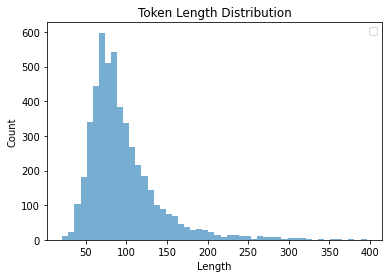

In [42]:
sentence_lengths = [len(s) for s in tokenized]

plt.hist(sentence_lengths, bins=50, alpha=0.6)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [43]:
print("질문 최대 길이:", np.max(sentence_lengths))

print("95% 답변 길이:", np.percentile(sentence_lengths, 95))

질문 최대 길이: 396
95% 답변 길이: 178.0


In [44]:
# 3. MAX_LENGTH 결정
model_wrapper.compute_max_length(tokenized)

In [45]:
# 4. 패딩 및 필터링
sentences, labels = model_wrapper.filter_and_pad(tokenized, labels)

### 레이블 인코딩

In [46]:
# 선택한 라벨 인코딩 방식
label_encoding_method = "int"  # 또는 "onehot"

encoded_labels = encode_labels(labels, method=label_encoding_method)

### 데이터셋 구성

In [47]:
from sklearn.model_selection import train_test_split

# 1. 전체 데이터를 train+val+test로 8:1:1 분할
sent_temp, sent_test, label_temp, label_test = train_test_split(
    sentences, encoded_labels, test_size=0.1, random_state=42, stratify=encoded_labels
)

sent_train, sent_val, label_train, label_val = train_test_split(
    sent_temp, label_temp, test_size=0.1111, random_state=42, stratify=label_temp
)

In [48]:
# 2. Dataset 구성
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((sent_train, label_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((sent_val, label_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((sent_test, label_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 모델 구성

### 콜백 설정

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# 이 실험의 이름 작성
experiment_name = f"base_daily{daily_data_num}"

train_log_path = f"../logs/{experiment_name}_train.csv"
test_log_path = f"../logs/{experiment_name}_test.txt"

checkpoint_cb = ModelCheckpoint(
    filepath=f"../ckpoints/{experiment_name}_best_model.h5",
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=2,
    verbose=1,
    restore_best_weights=True
)

csv_logger_cb = CSVLogger(train_log_path, append=True)

### 모델 생성

In [50]:
# 사용자 정의 매트릭(f1_score) 사용
from custom_metrics import *

model = model_wrapper.create_model()
loss_fn = "sparse_categorical_crossentropy" if label_encoding_method == "int" else "categorical_crossentropy"
model.compile(optimizer="adam", loss=loss_fn, metrics=[F1Score(num_classes=5, name="f1_score")])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 178)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 178, 128)          1045632   
_________________________________________________________________
transformer_block_2 (Transfo (None, 178, 128)          330240    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0   

## 모델 학습

In [51]:
model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=20, 
          callbacks=[checkpoint_cb, earlystop_cb, csv_logger_cb])

Epoch 1/20
59/59 [==============================] - 3s 33ms/step - loss: 1.5368 - f1_score: 0.2850 - val_loss: 1.1238 - val_f1_score: 0.3556

Epoch 00001: val_f1_score improved from -inf to 0.35563, saving model to ../ckpoints/base_daily1000_best_model.h5
Epoch 2/20
59/59 [==============================] - 2s 27ms/step - loss: 0.7664 - f1_score: 0.6682 - val_loss: 0.4562 - val_f1_score: 0.8205

Epoch 00002: val_f1_score improved from 0.35563 to 0.82054, saving model to ../ckpoints/base_daily1000_best_model.h5
Epoch 3/20
59/59 [==============================] - 2s 27ms/step - loss: 0.1911 - f1_score: 0.9376 - val_loss: 0.3078 - val_f1_score: 0.8723

Epoch 00003: val_f1_score improved from 0.82054 to 0.87226, saving model to ../ckpoints/base_daily1000_best_model.h5
Epoch 4/20
59/59 [==============================] - 2s 27ms/step - loss: 0.0373 - f1_score: 0.9877 - val_loss: 0.4018 - val_f1_score: 0.8889

Epoch 00004: val_f1_score improved from 0.87226 to 0.88891, saving model to ../ckpoi

### 모델 평가

In [53]:
# 저장된 best 모델 로드
best_model = tf.keras.models.load_model(
    f"../ckpoints/{experiment_name}_best_model.h5",
    custom_objects={
        "F1Score": F1Score,
        "TransformerBlock": TransformerBlock
    }
)

# 테스트 평가 및 로그 기록
test_loss, test_f1 = best_model.evaluate(test_dataset)
with open(test_log_path, "w") as f:
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test F1 Score: {test_f1:.4f}\n")
print(f"✅ 테스트 결과 저장 완료: {test_log_path}")

8/8 [==============================] - 0s 12ms/step - loss: 0.4563 - f1_score: 0.8885
✅ 테스트 결과 저장 완료: ../logs/base_daily1000_test.txt


## 모든 데이터로 재학습

### 데이터 재분리

In [63]:
sent_train, sent_val, label_train, label_val = train_test_split(
    sentences, encoded_labels, test_size=0.1, random_state=52, stratify=encoded_labels
)

train_dataset = tf.data.Dataset.from_tensor_slices((sent_train, label_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((sent_val, label_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### 모델 학습

In [65]:
model = model_wrapper.create_model()

model.compile(optimizer="adam", loss=loss_fn, metrics=[F1Score(num_classes=5, name="f1_score")])
model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=20, 
          callbacks=[checkpoint_cb, earlystop_cb, csv_logger_cb])

Epoch 1/20
67/67 [==============================] - 3s 32ms/step - loss: 1.2890 - f1_score: 0.4163 - val_loss: 0.7989 - val_f1_score: 0.5938

Epoch 00001: val_f1_score did not improve from 0.98900
Epoch 2/20
67/67 [==============================] - 2s 27ms/step - loss: 0.4512 - f1_score: 0.8242 - val_loss: 0.3327 - val_f1_score: 0.8817

Epoch 00002: val_f1_score did not improve from 0.98900
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 0.0965 - f1_score: 0.9697 - val_loss: 0.5909 - val_f1_score: 0.8587

Epoch 00003: val_f1_score did not improve from 0.98900
Epoch 4/20
67/67 [==============================] - 2s 27ms/step - loss: 0.0439 - f1_score: 0.9859 - val_loss: 0.5980 - val_f1_score: 0.8503

Epoch 00004: val_f1_score did not improve from 0.98900
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


## 테스트

### 테스트 데이터 로드

In [66]:
test_df = pd.read_csv('../data/original_data/test.csv')

### 테스트 결과(제출물) 저장 함수

In [67]:
def generate_submission_csv(model_wrapper, test_sentences, output_filename, experiment_name):
    # 0. 저장 경로 처리
    base_dir = "../data/results/"
    os.makedirs(base_dir, exist_ok=True)
    full_output_path = os.path.join(base_dir, output_filename)

    # 1. 베스트 모델 로드
    model_path=f"../ckpoints/{experiment_name}_best_model.h5"
    print(f"🔍 베스트 모델 로드 중: {model_path}")
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={"F1Score": F1Score, "TransformerBlock": TransformerBlock}
    )

    # 2. 정수 인코딩
    encoded = model_wrapper.encode(test_sentences)

    # 3. 패딩
    test_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        encoded, maxlen=model_wrapper.MAX_LENGTH, padding='post'
    )

    # 4. 예측
    model_path=f"../ckpoints/{experiment_name}_best_model.h5"
    predictions = model.predict(test_inputs)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    # 5. 제출 템플릿 불러오기 + 결과 저장
    template_path = "../data/original_data/submission.csv"
    submission_df = pd.read_csv(template_path)

    # 🔄 열 이름 변경 및 예측 결과 삽입
    submission_df.columns = ["idx", "target"]
    submission_df["target"] = predicted_labels

    # 저장
    submission_df.to_csv(full_output_path, index=False)
    print(f"✅ 케글 제출 파일 저장 완료: {full_output_path}")

    # 6. 사람이 확인할 수 있는 데이터프레임 반환
    readable_df = pd.DataFrame({
        "text": test_sentences,
        "예측 레이블 (정수)": predicted_labels,
        "예측 레이블 (한글)": decode_labels(predicted_labels)
    })

    return readable_df


### 테스트 결과 생성

In [68]:
# 테스트 문장 리스트 (예: test.csv에서 불러온 'text' 컬럼)
test_sentences = test_df['text'].tolist()

# 결과 저장
test_res = generate_submission_csv(model_wrapper, test_sentences, f"{experiment_name}.csv", experiment_name)

🔍 베스트 모델 로드 중: ../ckpoints/base_daily1000_best_model.h5
✅ 케글 제출 파일 저장 완료: ../data/results/base_daily1000.csv


In [69]:
test_res.head(10)

,text,예측 레이블 (정수),예측 레이블 (한글)
0,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,1,갈취 대화
1,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,2,직장 내 괴롭힘 대화
2,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2,직장 내 괴롭힘 대화
3,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,3,기타 괴롭힘 대화
4,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,2,직장 내 괴롭힘 대화
5,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,0,협박 대화
6,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...,0,협박 대화
7,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...,1,갈취 대화
8,안경 안쓰고 키작고통통해보이는 분이었는데 다안경안씀 쌍꺼풀없었던것같고 아 단발인가...,3,기타 괴롭힘 대화
9,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...,1,갈취 대화
